# Computations for vorticity, potential density, buoyancy and PV

In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
I_sit_at_GFDL = True

if I_sit_at_GFDL:
    dataurl = '/work/Raphael.Dussin/runs/OM4p5_sample/'
    ds = xr.open_mfdataset([f'{dataurl}/ocean_monthly_z.200301-200712.uo.nc',
                            f'{dataurl}/ocean_monthly_z.200301-200712.vo.nc',
                           f'{dataurl}/ocean_monthly_z.200301-200712.so.nc',
                           f'{dataurl}/ocean_monthly_z.200301-200712.thetao.nc'],
                           chunks={'time':1, 'z_l': 1}, combine='by_coords')
    dsgrid = xr.open_dataset(f'{dataurl}/ocean_monthly_z.static_novolcello.nc')
    ds = xr.merge([ds, dsgrid])
else:
    # open files from google cloud (useful if you run notebook in binder, slow otherwise)
    import gcsfs
    gcs = gcsfs.GCSFileSystem('gfdl-esgf-data-node')
    gcmap = gcsfs.GCSMap('example_rdussin/OM4p5_sample_store', gcs=gcs)
    ds = xr.open_zarr(gcmap, consolidated=True)

In [3]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X']);
print(ds)

<xarray.Dataset>
Dimensions:       (nv: 2, time: 60, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
Data variables:
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    so            

# Potential density

In [12]:
# Function to compute potential density
def pdens(S,theta):
    
    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464
    
    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals
    
    p = 100000.
    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S 
    
    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))
    
    return pot_dens    

In [13]:
#pot_density = pdens(ds.so, ds.thetao)
pt = xr.apply_ufunc(pdens, ds.so, ds.thetao, 
                    dask='parallelized', 
                    output_dtypes=[ds.so.dtype])

print(pt)

<xarray.DataArray (time: 60, z_l: 35, yh: 576, xh: 720)>
dask.array<pdens, shape=(60, 35, 576, 720), dtype=float32, chunksize=(1, 1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03


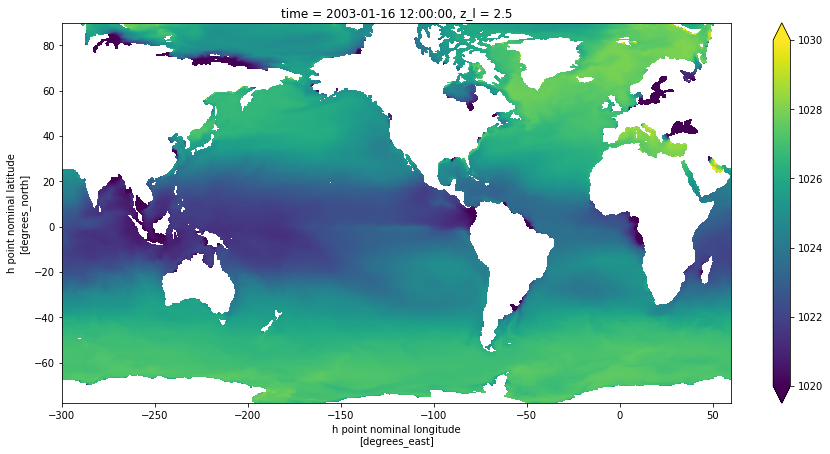

In [18]:
fig = plt.figure(figsize=(15,7))
pt.isel(z_l=0, time = 0).plot(vmin=1020, vmax=1030)

# Buoyancy and geostrophic shear

In [19]:
# Interpolate Coriolis on different grids
f_xh = grid.interp(ds.Coriolis, 'X', boundary='fill')
f_yh = grid.interp(ds.Coriolis, 'Y', boundary='fill')

# mean vertical density profile (area weighted mean) and density anomalies
dens_z = pt.mean('time')
dens_z = (dens_z*ds.areacello).sum(['xh', 'yh'])/(ds.areacello*dens_z/dens_z).sum(['xh','yh'])

dz = grid.diff(ds.z_i, 'Z', boundary='fill')
mean_density = (dens_z*dz).sum('z_l')/dz.sum('z_l')

anom_density = pt - mean_density
buoyancy = -g*anom_density/mean_density

g = 9.81

# density gradients in x and y
dens_x = grid.diff(anom_density*ds.dyt, 'X', boundary='fill')/ds.areacello_cu
dens_y = grid.diff(anom_density*ds.dxt, 'Y', boundary='fill')/ds.areacello_cv

# Geostrophic shear
dz_ug = dens_y*g/(f_xh*mean_density)
dz_vg = - dens_x*g/(f_yh*mean_density)

/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


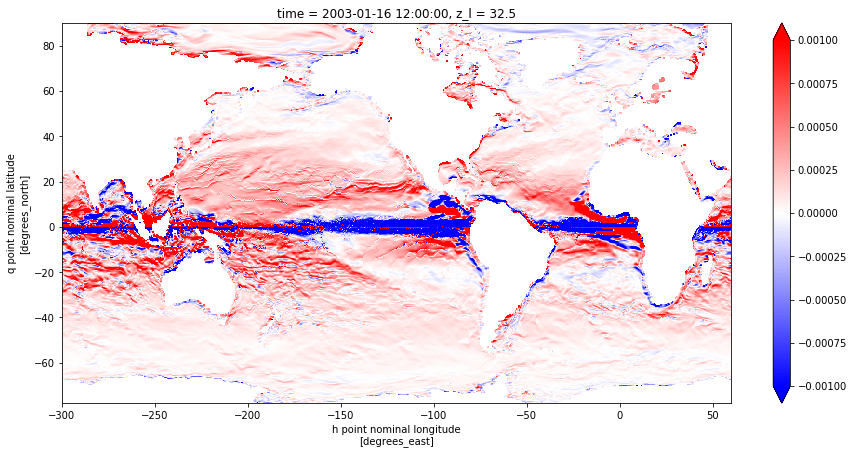

In [20]:
# Geostrophic Shear plot
tmp = dz_ug.isel({'z_l': slice(3,4), 'time' : slice(0,1)})

fig = plt.figure(figsize=(15,7))
tmp.plot(cmap = 'bwr', vmin = -.001, vmax = 0.001)